# Overview: Flow of Snowpark ML API / MLOps Hands-on-Lab

![End-to-end_demo.png](files/shared_uploads/joe.jordan@snowflake.com/assets/End_to_end_demo.png)




## Background Information

Tasty Bytes is one of the largest food truck networks in the world with localized menu options spread across 30 major cities in 15 countries. **Tasty Bytes is aiming to achieve 25% YoY sales growth over 5 years.**

As Tasty Bytes Data Scientists, we have been asked to support this goal by helping our food truck drivers more intelligently pick where to park for shifts. 

**We want to direct our trucks to locations that are expected to have the highest sales on a given shift.
This will maximize our daily revenue across our fleet of trucks.**

To provide this insight, we will use historical shift sales at each location to build a model. This data has been made available to us in Snowflake.Our model will provide the predicted sales at each location for the upcoming shift.



![problem_overview.png](files/shared_uploads/joe.jordan@snowflake.com/assets/problem_overview.png)







![snowpark_101.png](files/shared_uploads/joe.jordan@snowflake.com/assets/snowpark_101.png)





## Import Packages

Just like the Python packages we are importing, we will import the Snowpark modules that we need.
**Value**: Snowflake modules provide efficient ways to work with data and functions in Snowflake.



In [0]:
#%pip install -r /Workspace/Users/val.fontama@snowflake.com/assets/requirements.txt
%pip install -r /Workspace/assets/requirements.txt
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
# Import Packages
import pandas as pd
import plotly.express as px
import plotly.io as pio
import json
import sys
import cachetools
import getpass

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## Connect to Snowflake

Our assigned HOL Snowflake role, `<ROLEXXX>`, can access the data in your assigned `<SCHEMAXXX>` of the HOL database. We will use your assigned `<WHXXX>` warehouse that has been created as a dedicated compute for data science workloads.We will use these parameters and our Snowflake account credentials to connect to Snowflake and create a Snowpark session. 

**Value:** Secure and governed.



## Create your Snowflake data connection called "HOL`xxx`"

If you were assigned user`xxx`,

- set Name as HOL,`xxx`
- set Account as XXX-XXX,
- set Warehouse WH,`xxx`,,
- set Database as HOL,
- set Schemas as SCHEMA,`xxx`,,
- set Username as USER,`xxx`,,
- set Password as ,_(this is case sensitive)_
- set User Role as HOL,`xxx`

For instance, if you were assigned number 1, your data connection is:{ "username": "user1", "password": "test", "account": "XXXX-XXXX", "database": "HOL", "role": "HOL1", "warehouse": "HOL1_WH", "schema": "SCHEMA1" }



For instance, if you were assigned number 6, your data connection is:

If you were assigned user6, 

- set Name as HOL6
- set Account as XXX-XXX 
- set Warehouse as WH6
- set Database as HOL6
- set Schemas as ANALYTICS
- use Username & Password for Type
- set Username as USER6
- set Password as XXX ,_(this is case sensitive)_
- set User Role as ROLE6
- check Snowpark integration
- check Allow use in writeback cells
- select Create connection



In [0]:
# Get account credentials from a json file. /Workspace/assets/hol_auth.json
with open("/Workspace/Users/joe.jordan@snowflake.com/hol_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]
    database = data["database"]
    schema = data["schema"]
    role = data["role"]
    warehouse = data["warehouse"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": role,
    "warehouse": warehouse,
    "database": database,
    "schema": schema,
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [0]:
# Checking environment setting and versions associated with Snowpark connection
from snowflake.snowpark.version import VERSION
print("----------------------------------------")
snowflake_environment = session.sql('select current_warehouse(), current_database(), current_schema(), current_version()').collect()
snowpark_version = VERSION
print('Warehouse                   : {}'.format(snowflake_environment[0][0]))
print('Database                    : {}'.format(snowflake_environment[0][1]))
print('Schema                      : {}'.format(snowflake_environment[0][2]))
print('Snowflake version           : {}'.format(snowflake_environment[0][3]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))
print("----------------------------------------")

----------------------------------------
Warehouse                   : WH1
Database                    : HOL
Schema                      : SCHEMA1
Snowflake version           : 8.20.0
Snowpark for Python version : 1.17.0
----------------------------------------


# Part 1 - Use Snowpark to access and prepare data for modeling

![Part1.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Part1.png)



## Snowpark DataFrame

Let's create a Snowpark DataFrame containing our shift sales data from the **shift_sales_v** view in our Snowflake account using the Snowpark session.table function. A DataFrame is a data structure that contains rows and columns, similar to a SQL table.

**Value:** Familiar representation of data for Python users.



In [0]:
snowpark_df = session.table(database + "." + schema +".SHIFT_SALES_V")

## Preview the Data

With our Snowpark DataFrame defined, let’s use the .show() function to take a look at the first 10 rows.
**Value:** Instant access to data.



In [0]:
# Preview the data
# Use the .show() function to look at the first 10 rows.
# VALUE: instant access to data
# snowpark_df.show()
snowpark_df.limit(100).to_pandas().head()

,LOCATION_ID,CITY,DATE,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE
0,2574,New York City,2023-05-02,NaN,AM,5,2,8804190,40.731148,-74.003081
1,2574,New York City,2023-05-05,NaN,AM,5,5,8804190,40.731148,-74.003081
2,2574,New York City,2023-05-01,NaN,AM,5,1,8804190,40.731148,-74.003081
3,2574,New York City,2023-05-07,NaN,AM,5,0,8804190,40.731148,-74.003081
4,2574,New York City,2023-05-04,NaN,AM,5,4,8804190,40.731148,-74.003081


## Select, Filter, Sort

Notice the Null values for "shift_sales". Let's look at a single location.To do this, we will make another Snowpark DataFrame, location_df, from the above DataFrame and we will:

1. Select columns
2. Filter to a single location ID
3. Sort by date

**Value**: Efficient transformation pipelines using Python syntax and chained logic.



In [0]:
# Select
location_df = snowpark_df.select("date", "shift", "shift_sales", "location_id", "city")

# Filter
location_df = location_df.filter(F.col("location_id") == 1135)

# Sort
location_df = location_df.order_by(["date", "shift"], ascending=[0, 0])

# Display
location_df.show(n=20)

--------------------------------------------------------------------
|"DATE"      |"SHIFT"  |"SHIFT_SALES"  |"LOCATION_ID"  |"CITY"     |
--------------------------------------------------------------------
|2023-05-07  |PM       |NULL           |1135           |Vancouver  |
|2023-05-07  |AM       |NULL           |1135           |Vancouver  |
|2023-05-06  |PM       |NULL           |1135           |Vancouver  |
|2023-05-06  |AM       |NULL           |1135           |Vancouver  |
|2023-05-05  |PM       |NULL           |1135           |Vancouver  |
|2023-05-05  |AM       |NULL           |1135           |Vancouver  |
|2023-05-04  |PM       |NULL           |1135           |Vancouver  |
|2023-05-04  |AM       |NULL           |1135           |Vancouver  |
|2023-05-03  |PM       |NULL           |1135           |Vancouver  |
|2023-05-03  |AM       |NULL           |1135           |Vancouver  |
|2023-05-02  |PM       |NULL           |1135           |Vancouver  |
|2023-05-02  |AM       |NULL      

We can see that shift sales are populated 8 days prior to the latest date in the data. The **missing values** represent future dates that do not have shift sales yet.

## Snowpark works in two main ways:

1. Snowpark code translated and executed as SQL on Snowflake
2. Python functions deployed in a secure sandbox in Snowflake



![snowparkoverview.png](files/shared_uploads/joe.jordan@snowflake.com/assets/snowparkoverview.png)


Here's the value of using Snowpark:

![SnowparkValue.png](files/shared_uploads/joe.jordan@snowflake.com/assets/SnowparkValue.png)


## Explain the Query

Let's look at what was executed in Snowflake to create our location_df DataFrame.

The translated SQL query can be seen in the Snowsight interface under _Activity_ in the _Query History_ or directly in our notebook by using the explain() function. **Value:** Transparent execution and compute usage.



![query_history.png](files/shared_uploads/joe.jordan@snowflake.com/assets/query_history.png)





In [0]:
location_df.explain()

---------DATAFRAME EXECUTION PLAN----------
Query List:
1.
SELECT "DATE", "SHIFT", "SHIFT_SALES", "LOCATION_ID", "CITY" FROM hol.schema1.SHIFT_SALES_V WHERE ("LOCATION_ID" = 1135 :: INT) ORDER BY "DATE" DESC NULLS LAST, "SHIFT" DESC NULLS LAST
Logical Execution Plan:
GlobalStats:
    partitionsTotal=2
    partitionsAssigned=2
    bytesAssigned=24747520
Operations:
1:0     ->Result  SHIFT_SALES.DATE, SHIFT_SALES.SHIFT, SHIFT_SALES.SHIFT_SALES, SHIFT_SALES.LOCATION_ID, SHIFT_SALES.CITY  
1:1          ->Sort  SHIFT_SALES.DATE DESC NULLS LAST, SHIFT_SALES.SHIFT DESC NULLS LAST  
1:2               ->Filter  SHIFT_SALES.LOCATION_ID = 1135  
1:3                    ->TableScan  HOL.SCHEMA1.SHIFT_SALES  LOCATION_ID, CITY, DATE, SHIFT_SALES, SHIFT  {partitionsTotal=2, partitionsAssigned=2, bytesAssigned=24747520}

--------------------------------------------


![data_exploration.png](files/shared_uploads/joe.jordan@snowflake.com/assets/data_exploration.png)


## Compare DataFrame Size

Let's bring a sample of our Snowflake dataset to our Python environment in a pandas DataFrame using the to_pandas() function. We will compare how much memory is used for the pandas DataFrame compared to the Snowpark DataFrame. As we will see, no memory is used for the Snowpark DataFrame in our Python environment. All data in the Snowpark DataFrame remains on Snowflake.
**Value:** No copies or movement of data when working with Snowpark DataFrames.



In [0]:
# Bring 10,000 rows from Snowflake to pandas
pandas_df = snowpark_df.limit(10000).to_pandas()

# Get Snowpark DataFrame size
snowpark_size = sys.getsizeof(snowpark_df) / (1024*1024)
print(f"Snowpark DataFrame Size (snowpark_df): {snowpark_size:.2f} MB")

# Get pandas DataFrame size
pandas_size = sys.getsizeof(pandas_df) / (1024*1024)
print(f"Pandas DataFrame Size (pandas_df): {pandas_size:.2f} MB")

Snowpark DataFrame Size (snowpark_df): 0.00 MB
Pandas DataFrame Size (pandas_df): 1.86 MB


## Data Exploration

Here, we will use Snowpark to explore our data. A common pattern for exploration is to use Snowpark to manipulate our data and then bring an aggregate table to our Python environment for visualization.
**Value:** - Native Snowflake performance and scale for aggregating large datasets. - Easy transfer of aggregate data to the client-side environment for visualization.
As we explore our data, we will highlight what is being done in Snowflake and what we are transferring to our client-side environment (Python notebook environment) for visualization.



## How many rows are in our data?

This will give us an idea of how we might need to approach working with this data. Do we have enough data to build a meaningful model? What compute might be required? Will we need to sample the data?
**What's happening where?:** Rows counted in Snowflake. No data transfer.



In [0]:
#Use the .count() function
snowpark_df.count()

1938202

## Let's calculate some descriptive statistics.

We use the Snowpark describe() function to calculate summary statistics and then bring the aggregate results into a pandas DataFrame to visualize in a formatted table.
**What's happening where?:** Summary statistics calculated in Snowflake. Transfer aggregate summary statistics for client-side visualization.



In [0]:
#Use the Snowpark DataFrame .describe function. You need to need to visualize from a pandas DataFrame
snowpark_df.describe().to_pandas()

,SUMMARY,LOCATION_ID,CITY,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE
0,min,1.001000e+03,Barcelona,7.600000e-01,AM,1.000000e+00,0.000000e+00,1.056610e+05,-3.832745e+01,-1.232431e+02
1,stddev,4.234979e+03,None,4.381358e+02,None,3.223800e+00,1.996656e+00,4.566943e+06,2.839821e+01,7.830981e+01
2,max,1.551700e+04,Warsaw,4.785360e+03,PM,1.200000e+01,6.000000e+00,1.634983e+07,5.948668e+01,1.513234e+02
3,mean,8.119924e+03,None,6.092432e+02,None,6.169526e+00,3.000784e+00,4.325339e+06,3.168076e+01,-3.415415e+00
4,count,1.938202e+06,1938202,1.755096e+06,1938202,1.938202e+06,1.938202e+06,1.938202e+06,1.938202e+06,1.938202e+06


In [0]:
# What are the numeric columns?
# Define Snowflake numeric types
numeric_types = [T.DecimalType, T.DoubleType, T.FloatType, T.IntegerType, T.LongType]

# Get numeric columns
numeric_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in numeric_types]
numeric_columns

['LOCATION_ID',
 'SHIFT_SALES',
 'MONTH',
 'DAY_OF_WEEK',
 'CITY_POPULATION',
 'LATITUDE',
 'LONGITUDE']

In [0]:
# What are the categorical columns?
# Define Snowflake categorical types
categorical_types = [T.StringType]

# Get categorical columns
categorical_columns = [col.name for col in snowpark_df.schema.fields if type(col.datatype) in categorical_types]
categorical_columns

['CITY', 'SHIFT']

<Axes: ylabel='CITY'>

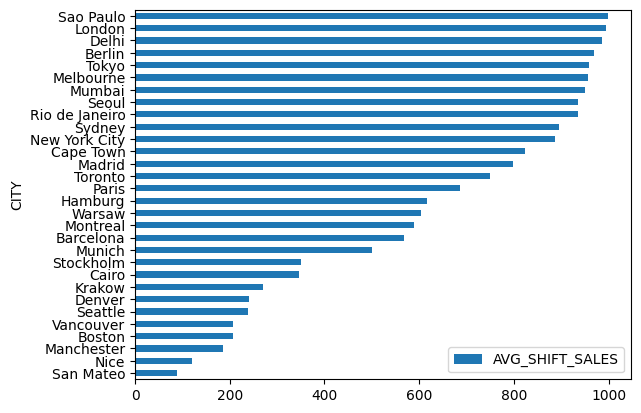

In [0]:
# What are the average shift sales (USD) by city?
# Group by city and average shift sales
analysis_df = snowpark_df.group_by("city").agg(F.mean("shift_sales").alias("avg_shift_sales"))

# Sort by average shift sales
analysis_df = analysis_df.sort("avg_shift_sales", ascending=True)

# Pull to pandas and plot
analysis_df.to_pandas().plot.barh(x="CITY", y="AVG_SHIFT_SALES")

![feature_engineering.png](files/shared_uploads/joe.jordan@snowflake.com/assets/feature_engineering.png)


## Feature Engineering

Now let's keep revelant columns and transform columns to create features needed for our prediction model.To make some of our features more useful, we will normalize them using standard preprocessing techniques, such as One-Hot Encoding and MinMaxScaling. With SnowparkML, you can use a standard sklearn-style API to execute fully distributed feature engineering preprocessing tasks on Snowflake compute, with zero data movement. Let's fit a scaler and encoder to our data, then use it to transform the data, producing new feature columns.


**Value:** The Snowpark syntax makes pipelines easy to implement and understand. The syntax also allows for easy migration of Spark pipelines to Snowflake.


**All transformations for feature engineering in this notebook will be executed on Snowflake compute.**

Notice what we haven't had to do? No tuning, maintenance, or operational overhead. We just need a role, warehouse, and access to the data.
**Value**: Near-zero maintenance. Focus on the work that brings value.



## Create a Rolling Average Feature

We will use a Snowflake window function to get a **rolling shift average by location** over time. Window functions allow us to aggregate on a "moving" group of rows.

#### **Step 1. Create a Window**

Our window will partition the data by location and shift. It will order rows by date. It will include all rows prior to the current date of the observation it is aggregating for.



In [0]:
window_by_location_all_days = (
    Window.partition_by("location_id", "shift")
    .order_by("date")
    .rows_between(Window.UNBOUNDED_PRECEDING, Window.CURRENT_ROW - 1)
)

#### **Step 2. Aggregate across the Window**



In [0]:
snowpark_df = snowpark_df.with_column(
    "avg_location_shift_sales", 
    F.avg("shift_sales").over(window_by_location_all_days)
)

## Impute Missing Values

The rolling average feature we just created is missing if there are no prior shift sales at that location. We will replace those missing values with 0.



In [0]:
snowpark_df = snowpark_df.fillna(value=0, subset=["avg_location_shift_sales"])

## Leverage Snowpark ML Modeling API to create features

Snowpark ML provides APIs to support each stage of an end-to-end machine learning development and deployment process and includes two key components: [Snowpark ML Modeling](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling) and [Snowpark ML Ops](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-mlops-model-registry).

[Snowpark ML Modeling](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-modeling) supports data preprocessing, feature engineering, and model training in Snowflake using popular machine learning frameworks, such as scikit-learn, xgboost, and lightgbm. This API also includes a preprocessing module that can use compute resources provided by a Snowpark-optimized warehouse to provide scalable data transformations.

Snowpark ML Operations (MLOps), featuring the [Snowpark ML Model Registry](https://docs.snowflake.com/en/developer-guide/snowpark-ml/snowpark-ml-mlops-model-registry), complements the Snowpark ML Development API. The model registry allows secure deployment and management of models in Snowflake, and supports models trained both inside and outside of Snowflake.



Here are a Snowpark Features commonly used for Data Engineering tasks:

![Snowpark4DE.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Snowpark4DE.png)



Here are Snowpark Features commonly used by Data Scientists for ML efforts:

![Snowpark4DS1.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Snowpark4DS.png)


In [0]:
session.sql("alter warehouse " + warehouse + " set warehouse_size = LARGE").collect()

[Row(status='Statement executed successfully.')]

In [0]:
# Import Snowpark ML: Machine Learning Toolkit for Snowflake
import snowflake.ml.modeling.preprocessing as snowmlpp

# Define our scaler and ordinal encoding functions

# Snowpark ML scaler (MinMaxScaler) is used to shrink data within the given range, usually of 0 to 1. 
# It transforms data by scaling features to a given range. It scales the values to a specific value range without changing the shape of the original distribution.
# For the Tasty_Bytes data, use MinMaxScaler to normalize "CITY_POPULATION" into "CITY_POPULATION_NORM" with values between 0 and 1.

def fit_scaler(session, df):
    mm_target_columns = ["CITY_POPULATION"]
    mm_target_cols_out = ["CITY_POPULATION_NORM"]
    snowml_mms = snowmlpp.MinMaxScaler(input_cols=mm_target_columns, output_cols=mm_target_cols_out)
    snowml_mms.fit(df)
    return snowml_mms

# Snowpark ML ordinal encoding (OE) is used to improve model performance by providing more information to the model about categorical variables. 
# It can help to avoid the problem of ordinality, which can occur when a categorical variable has a natural ordering (e.g. “small”, “medium”, “large”).
# For the Tasty_Bytes data, use OE to change "SHIFT" which is currently AM or PM into and integer representation of "SHIFT_OHE" is 1.0 or 0.0. 

def fit_oe(session, df):
    oe_target_cols = ["SHIFT"]
    oe_output_cols = ["SHIFT_OE"]
    snowml_oe = snowmlpp.OrdinalEncoder(input_cols=oe_target_cols, output_cols=oe_output_cols)
    snowml_oe.fit(df)
    return snowml_oe

In [0]:
# Run Snowpark ML preprocessing functions against our feature data

# For the Tasty_Bytes data, use MinMaxScaler to normalize "CITY_POPULATION" into "CITY_POPULATION_NORM" with values between 0 and 1.
snowml_mms = fit_scaler(session, snowpark_df)
normed_df = snowml_mms.transform(snowpark_df)

# For the Tasty_Bytes data, use OneHotEncoder to change "SHIFT" which is currently AM or PM into and integer representation of "SHIFT_OHE_AM" is 1 or 0 and "SHIFT_OHE_PM" is 1 or 0. 
snowml_oe = fit_oe(session, normed_df)
oe_df = snowml_oe.transform(normed_df)
#oe_df.show()
oe_df.limit(100).to_pandas().head()

,SHIFT_OE,CITY_POPULATION_NORM,LOCATION_ID,CITY,DATE,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES
0,1.0,0.053749,10594,Stockholm,2016-03-05,263.99,PM,3,6,978770,59.34722,18.101904,0.000000
1,1.0,0.053749,10594,Stockholm,2016-05-31,153.11,PM,5,2,978770,59.34722,18.101904,263.990000
2,1.0,0.053749,10594,Stockholm,2016-06-06,334.75,PM,6,1,978770,59.34722,18.101904,208.550000
3,1.0,0.053749,10594,Stockholm,2016-06-15,217.30,PM,6,3,978770,59.34722,18.101904,250.616667
4,1.0,0.053749,10594,Stockholm,2016-07-22,144.98,PM,7,5,978770,59.34722,18.101904,242.287500


## Filter to Historical Data

Our data includes placeholders for future data with missing shift sales. The future data represents the next 7 days of shifts for all locations. The historical data has shift sales for all locations where a food truck parked during a shift. We will only use historical data when training our model and will filter out the dates where the shift_sales column is missing.



In [0]:
# Data Science best practice: Always perform data quality on your training set e.g. remove nulls or invalid cells as they are the biggest problem in a training set as they output high false positives

# Specifically for Tasty_Bytes data, dates where "shift_sales" are null values reflect future dates where sales need to be predicted.
# Filter out these future dates so these records will not be used in model training. 
historical_df = oe_df.filter(F.col("shift_sales").is_not_null())

## Persist Transformations

If we want to save the changes we can either save it as a table, meaning the SQL generated by the DataFrame is executed and the result is stored in a table or as a view where the DataFrame SQL will be the definition of the view.
**save_as_table** saves the result in a table, if **mode='overwrite'** then it will also replace the data that is in it.



In [0]:
# Let's select 
historical_df.write.save_as_table(table_name=schema + '.INPUT_DATA', mode='overwrite')
session.table('INPUT_DATA').show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SHIFT_OE"  |"CITY_POPULATION_NORM"  |"LOCATION_ID"  |"CITY"          |"DATE"      |"SHIFT_SALES"  |"SHIFT"  |"MONTH"  |"DAY_OF_WEEK"  |"CITY_POPULATION"  |"LATITUDE"  |"LONGITUDE"  |"AVG_LOCATION_SHIFT_SALES"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1.0         |0.40889463727601966     |10016          |Rio de Janeiro  |2015-07-29  |621.99         |PM       |7        |3              |6747815            |-22.956992  |-43.176834   |0.0                         |
|1.0         |0.40889463727601966     |10016          |Rio de Janeiro  |2015-08-31  |171.87         |PM       |8        |1              |6747815

# Part 2 - Use Snowflake Cortex ML-Based Function for Time-Series Forecasting

![Part2.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Part2.png)


## Snowflake Cortex ML Functions

Time-Series Forecasting is part of Snowflake Cortex, Snowflake’s intelligent, fully-managed AI and ML service. This feature is part of the Snowflake Cortex ML-based function suite. Forecasting employs a machine learning algorithm to predict future data by using historical time series data.

![CortexML.png](files/shared_uploads/joe.jordan@snowflake.com/assets/CortexML.png)


Time series forecasting produces univariate predictions of future data based on historical input data. A common use case is to forecast sales based on seasonality and other factors.The historical data must include:

- A timestamp column.
- A target value column representing some quantity of interest at each timestamp.


The historical data can also include additional columns that might have influenced the target value ([exogenous variables](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables)). These can be numbers or text. The nature (categorical or continuous) of each such column is automatically detected.

This historical data is used to train a machine learning model that produces a forecast of the value column at future timestamps. The model is a schema-level object and can be used for multiple forecasts after it is trained.

Forecasting works with either single-series or multi-series data. Multi-series data represents multiple independent threads of events. For example, if you have sales data for multiple stores, each store’s sales can be forecast separately by a single model based on the store identifier.

![MLPF_Forecast.png](files/shared_uploads/joe.jordan@snowflake.com/assets/MLPF_Forecast.png)


To produce forecasts of time series data, use the Snowflake built-in class [FORECAST](https://docs.snowflake.com/en/sql-reference/classes/forecast), and follow these steps:

1. [Create a forecast model object](https://docs.snowflake.com/en/sql-reference/classes/forecast.html#label-class-forecast-create) passing in a reference to the training data.This object will fit (train) a model to the training data that you provide. The model is a schema-level object.
2. Using this forecast model object, call [CREATE SNOWFLAKE.ML.FORECAST](https://docs.snowflake.com/en/sql-reference/classes/forecast.html#label-class-forecast-create) to produce a forecast, passing in information about the future period (that is, the number of time steps and values for any non-timestamp features).The method uses the model to produce a forecast.



#### About the Forecasting Algorithm

The forecasting algorithm is powered by a [gradient boosting machine](https://en.wikipedia.org/wiki/Gradient_boosting) (GBM). Like an [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) model, it uses a differencing transformation to model data with a non-stationary trend and uses auto-regressive lags of the historical target data as model features.

Additionally, the algorithm uses rolling averages of historical target data to help predict trends and automatically produces cyclic calendar features (such as day of week and week of year) from timestamp data.

You can fit models with only historical target and timestamp data, or you may include exogenous data (features) that might have influenced the target value. Exogenous variables can be numerical or categorical and may be NULL (rows containing NULLs for exogenous variables are not dropped).

The algorithm does not rely on one-hot encoding when training on categorical features, so you can use categorical data with many dimensions (high cardinality).

For more details about Snowflake's ML-Powered Forecasting Algorithm and how to use, please see [https://docs.snowflake.com/en/user-guide/ml-powered-forecasting#about-the-forecasting-algorithm](https://docs.snowflake.com/en/user-guide/ml-powered-forecasting#about-the-forecasting-algorithm)



Here's a short video presenting [Snowflake ML Powered Functions: Forecasting, Anomaly Detection, Contribution Explorer](https://www.youtube.com/watch?v=8WgVTf3im7w)

Check out the code at: [https://github.com/Snowflake-Labs/sf-...](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbUZVS1dBWGhmYlVJUEt4MUsyWlY1VzVNbHVTUXxBQ3Jtc0ttaURLdms3dE4xeHZuVHVtVmlOZmxOQWRiOXA4RjNweWJuRTBSSkJkMnhxVUJseFhNdnBZQkZVbEVnWGdBbnFsODZ6TlZkeV9wSmo1NzhtbUZnOTdfYWE2czRjSnBmRTNkYWZpRm5lckxTay1lTi1Edw&q=https%3A%2F%2Fgithub.com%2FSnowflake-Labs%2Fsf-samples%2Fblob%2Fmain%2Fsamples%2FML%2520Powered%2520Functions%2FJune%25202023%2520MLPF%2520Demos.sql&v=8WgVTf3im7w)





In [0]:
session.sql('SELECT * FROM SALES_FORECAST_INPUT LIMIT 10;').collect()

[Row(TIMESTAMP=datetime.datetime(2023, 5, 6, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='Mothers Favorite', TOTAL_SOLD=20),
 Row(TIMESTAMP=datetime.datetime(2023, 5, 8, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='Bottled Soda', TOTAL_SOLD=165),
 Row(TIMESTAMP=datetime.datetime(2023, 5, 4, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='Ice Tea', TOTAL_SOLD=189),
 Row(TIMESTAMP=datetime.datetime(2023, 5, 14, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='Wonton Soup', TOTAL_SOLD=20),
 Row(TIMESTAMP=datetime.datetime(2023, 5, 14, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='Breakfast Crepe', TOTAL_SOLD=28),
 Row(TIMESTAMP=datetime.datetime(2023, 5, 5, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='Lean Burrito Bowl', TOTAL_SOLD=12),
 Row(TIMESTAMP=datetime.datetime(2023, 5, 2, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='The Classic', TOTAL_SOLD=15),
 Row(TIMESTAMP=datetime.datetime(2023, 5, 17, 0, 0), PRIMARY_CITY='Vancouver', MENU_ITEM_NAME='Buffalo Mac & Cheese'

In [0]:
# Create view for lobster sales
session.sql('''CREATE OR REPLACE VIEW lobster_sales AS (SELECT timestamp, total_sold \
            FROM SALES_FORECAST_INPUT \
            WHERE menu_item_name LIKE 'Lobster Mac & Cheese');''').collect()

[Row(status='View LOBSTER_SALES successfully created.')]

In [0]:
# Create Cortex ML forecast called lobstermac_forecast
session.sql('''CREATE OR REPLACE snowflake.ml.forecast lobstermac_forecast \
            (INPUT_DATA => SYSTEM$REFERENCE('VIEW', 'lobster_sales'), \
            TIMESTAMP_COLNAME => 'TIMESTAMP', \
            TARGET_COLNAME => 'TOTAL_SOLD');''').collect()

[Row(status='Instance LOBSTERMAC_FORECAST successfully created.')]

In [0]:
# Show models to confirm training has completed: 
forecast = session.sql('SHOW snowflake.ml.forecast;')
#forecast.show()
forecast.limit(100).to_pandas().head()

,created_on,name,database_name,schema_name,current_version,comment,owner,owner_role_type
0,2024-05-23 05:38:14.648000-07:00,LOBSTERMAC_FORECAST,HOL,SCHEMA1,12.0,None,ROLE1,ROLE


# Part 3 - Use Snowpark to train a model

![Part3.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Part3.png)


![model_training.png](files/shared_uploads/joe.jordan@snowflake.com/assets/model_training.png)


## Drop Columns

Let's return to the original prepared table, with all cities listed, and drop columns that will not be used in the model.



In [0]:
prepared_df = historical_df.drop("location_id", "city_population", "shift", "city", "date")
#prepared_df.show()
prepared_df.limit(100).to_pandas().head()

,SHIFT_OE,CITY_POPULATION_NORM,SHIFT_SALES,MONTH,DAY_OF_WEEK,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES
0,0.0,0.315528,1473.08,1,6,-33.866793,151.206949,0.000000
1,0.0,0.315528,329.22,10,2,-33.866793,151.206949,1473.080000
2,0.0,0.315528,515.36,11,4,-33.866793,151.206949,901.150000
3,0.0,0.315528,523.88,11,5,-33.866793,151.206949,772.553333
4,0.0,0.315528,619.15,1,6,-33.866793,151.206949,710.385000


## Build a simple XGBoost Regression Model on Snowflake

We will now use our training data to train a linear regression model on Snowflake.Recall from above, the two main ways that Snowpark works:

1. Snowpark code translated and executed as SQL on Snowflake
2. Python functions deployed in a secure sandbox in Snowflake

We will be leveraging the deployment of Python functions into Snowflake for training and model deployment.



In [0]:
# Retrieve column names needed in the next code block to populate feature_column_names
prepared_df.columns

['SHIFT_OE',
 'CITY_POPULATION_NORM',
 'SHIFT_SALES',
 'MONTH',
 'DAY_OF_WEEK',
 'LATITUDE',
 'LONGITUDE',
 'AVG_LOCATION_SHIFT_SALES']

In [0]:
# Let's define relevant features needed for the prediction model.
LABEL_COLUMNS = ["SHIFT_SALES"]
OUTPUT_COLUMNS = ["PRED_SHIFT_SALES"]
FEATURE_COLUMN_NAMES = ["SHIFT_OE", "CITY_POPULATION_NORM", "MONTH", "DAY_OF_WEEK","LATITUDE","LONGITUDE","AVG_LOCATION_SHIFT_SALES"]

input_df = prepared_df.select(*LABEL_COLUMNS, *FEATURE_COLUMN_NAMES)
#input_df.show()
input_df.limit(100).to_pandas().head()

,SHIFT_SALES,SHIFT_OE,CITY_POPULATION_NORM,MONTH,DAY_OF_WEEK,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES
0,405.72,1.0,0.535486,6,2,40.838073,-73.941439,0.00
1,476.68,1.0,0.535486,8,1,40.838073,-73.941439,405.72
2,473.60,1.0,0.535486,9,5,40.838073,-73.941439,441.20
3,466.76,1.0,0.535486,9,2,40.838073,-73.941439,452.00
4,666.55,1.0,0.535486,12,0,40.838073,-73.941439,455.69


SnowparkML also includes metric calculations such as correlations, and more. We will use the SnowparkML correlation method on our input dataframe to identify any linearly correlated features to the output. We'll also use matplotlib to plot the resulting matrix. Notice that all of the correlation calculations are pushed down to Snowflake!



In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from snowflake.ml.modeling.metrics.correlation import correlation
corr_df = correlation(df=input_df)

<Axes: >

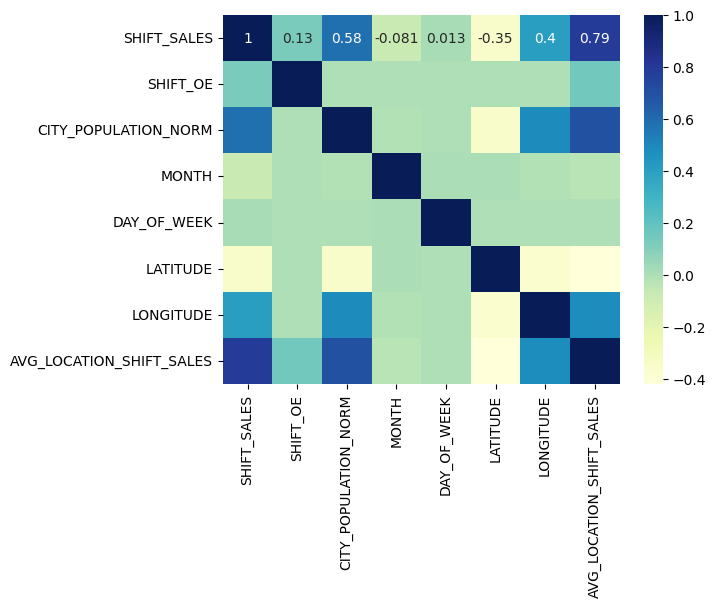

In [0]:
# Return only the correlation summary results to generate this heatmap
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)

What's great about this, is that we are using a lot of Snowpark components under the hood- the dataframe API, SQL, Python stored procedures and more. But with the new SnowparkML API, data scientists can take advantage of all that Snowpark affords them, while using common, familiar APIs that match how they do their work today.

Now that we have our feature data, let's actually fit an XGBoost model to our features to attempt to predict future sales. We'll fit several different models with different hyperparameters, and then show how we can use the Snowpark Model Registry to select our best-fit model.



In [0]:
# Split the data into train and test sets
train_df, test_df = input_df.random_split(weights=[0.9, 0.1], seed=98)

## What's happening when you leverage Snowpark ML Modeling API?

Let's run our training job using the SnowparkML Modeling API- this will push down our model training to run on Snowflake, and you'll notice that the type of the model object returend is a SnowparkML XGBClassifier- this has some benefits, but also is fully compatible with the standard sklearn/xgboost model objects.

- The model.fit() function actually creates a temporary stored procedure in the background. This also means that the model training is a single-node operation. Be sure to use a Snowpark Optimized Warehouse if you need more memory. We are just using an XS Standard Virtual Warehouse here, which we created at the beginning of this quickstart.
- The model.predict() function actually creates a temporary vectorized UDF in the background, which means the input DataFrame is batched as Pandas DataFrames and inference is parallelized across the batches of data. You can check the query history once you execute the following cell to check.

![Snowpark_ML_API.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Snowpark_ML_API.png)


In [0]:
from snowflake.ml.modeling.xgboost import XGBRegressor
# Define the XGBRegressor
regressor = XGBRegressor(
    label_cols = LABEL_COLUMNS,
    input_cols = FEATURE_COLUMN_NAMES,
    output_cols = OUTPUT_COLUMNS
)

# Train
regressor.fit(train_df)

# Predict
result = regressor.predict(test_df)

The version of package 'snowflake-snowpark-python' in the local environment is 1.17.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


In [0]:
# Just to illustrate, we can also pass in a Pandas DataFrame to Snowpark ML's model.predict()
regressor.predict(test_df.to_pandas())
# try 
regressor.predict(test_df)

In [0]:
test_df.limit(10).to_pandas().head()

,SHIFT_SALES,SHIFT_OE,CITY_POPULATION_NORM,MONTH,DAY_OF_WEEK,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES
0,394.74,1.0,0.053749,6,1,59.347220,18.101904,261.239167
1,311.64,1.0,0.053749,6,1,59.347220,18.101904,305.115909
2,276.55,1.0,0.053749,6,3,59.347220,18.101904,305.399565
3,618.17,1.0,0.053749,6,1,59.347220,18.101904,313.069375
4,901.29,0.0,0.225548,4,3,52.501136,13.302495,502.440000


Let's analyze the results using Snowpark ML's MAPE.



In [0]:
# Use Snowpark ML metrics to calculate
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error, mean_squared_error

# Predict
results = regressor.predict(test_df)

# Calculate MAPE
mape = mean_absolute_percentage_error(df=results, y_true_col_names=LABEL_COLUMNS, y_pred_col_names=OUTPUT_COLUMNS)

# Calculate MSE
mse = mean_squared_error(df=results, y_true_col_names=LABEL_COLUMNS, y_pred_col_names=OUTPUT_COLUMNS)

results.select([*LABEL_COLUMNS, *OUTPUT_COLUMNS]).show()
print(f'''Mean absolute percentage error: {mape}''')
print(f'''Mean squared error: {mse}''')

--------------------------------------
|"SHIFT_SALES"  |"PRED_SHIFT_SALES"  |
--------------------------------------
|394.74         |245.19151306152344  |
|311.64         |289.1174621582031   |
|276.55         |331.7347412109375   |
|618.17         |289.1174621582031   |
|901.29         |680.1103515625      |
|261.89         |739.5217895507812   |
|779.83         |952.1456909179688   |
|1150.8         |936.9378662109375   |
|1543.25        |1053.4215087890625  |
|599.07         |1019.264404296875   |
--------------------------------------

Mean absolute percentage error: 0.38014297231282707
Mean squared error: 59543.087155082205


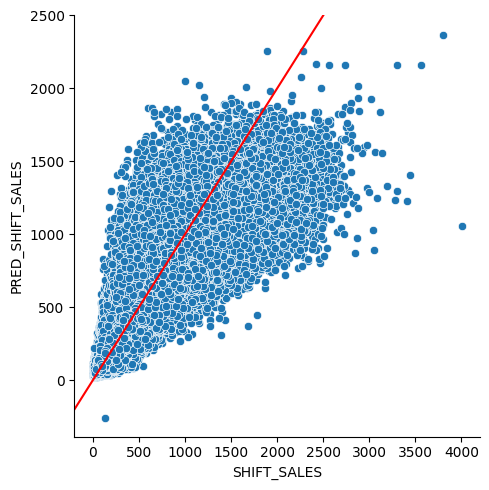

In [0]:
# Plot actual vs predicted 
g = sns.relplot(data=results["SHIFT_SALES", "PRED_SHIFT_SALES"].to_pandas().astype("float64"), x="SHIFT_SALES", y="PRED_SHIFT_SALES", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

## Snowpark ML's GridSearchCV()

Now, let's use Snowpark ML's GridSearchCV() function to find optimal model parameters.



In [0]:
from snowflake.ml.modeling.model_selection import GridSearchCV

grid_search = GridSearchCV(
estimator=XGBRegressor(),
param_grid={
"n_estimators":[25, 50],
"learning_rate":[0.4, 0.5],
},
n_jobs = -1,
scoring="neg_mean_absolute_percentage_error",
input_cols=FEATURE_COLUMN_NAMES,
label_cols=LABEL_COLUMNS,
output_cols=OUTPUT_COLUMNS
)


# Train
grid_search.fit(train_df)

The version of package 'snowflake-snowpark-python' in the local environment is 1.17.0, which does not fit the criteria for the requirement 'snowflake-snowpark-python<2'. Your UDF might not work when the package version is different between the server and your local environment.
Package 'fastparquet' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


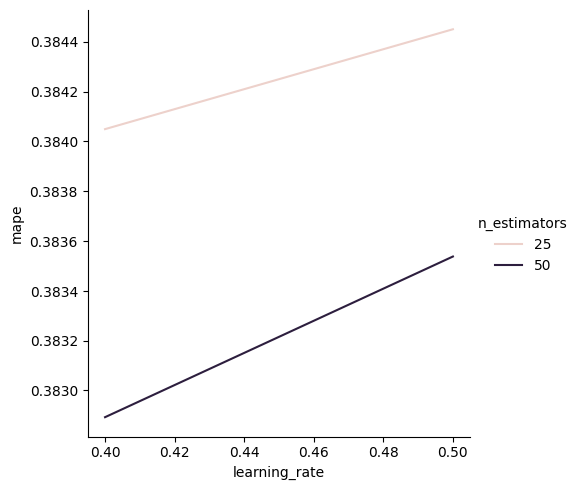

In [0]:
# Let's analyze the grid_search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

In [0]:
# Let's save our optimal model and its metadata:
optimal_model = grid_search.to_sklearn().best_estimator_
optimal_n_estimators = grid_search.to_sklearn().best_estimator_.n_estimators
optimal_learning_rate = grid_search.to_sklearn().best_estimator_.learning_rate


optimal_mape = gs_results_df.loc[(gs_results_df['n_estimators']==optimal_n_estimators) &
                        (gs_results_df['learning_rate']==optimal_learning_rate),'mape'].values[0]

## **Scale down your assigned Snowflake compute warehouse.**



In [0]:
# Decrease size of Snowflake compute warehouse to XSMALL
session.sql("alter warehouse " + warehouse + " set warehouse_size = XSMALL").collect()

[Row(status='Statement executed successfully.')]

# Part 4 - Use Snowpark for MLOps

![Part4.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Part4.png)



![model_deployment.png](files/shared_uploads/joe.jordan@snowflake.com/assets/model_deployment.png)


## Now let's use Snowflake's ML Model Registry

Model Registry was created to support model management operations including model registration, versioning, metadata and audit trails. Integrated deployment infrastructure for batch inference is a critical ease-of-use feature. Users can deploy ML models for batch inference from the registry directly into a Snowflake Warehouse as a vectorized UDF, or as a service to a customer-specified Compute Pool in Snowpark Container Services.

Snowflake's Model Registry supports SciKitLearn, XGBoost, Pytorch, Tensorflow and MLFlow (via the pyfunc interface) models.

![ModelRegistry.png](files/shared_uploads/joe.jordan@snowflake.com/assets/ModelRegistry.png)


Model Registry allows easy deployment of pre-trained open-source models from providers such as HuggingFace. See this blog for more details: [https://medium.com/snowflake/whats-in-a-name-model-naming-versioning-in-snowpark-model-registry-b5f7105fd6f6](https://medium.com/snowflake/whats-in-a-name-model-naming-versioning-in-snowpark-model-registry-b5f7105fd6f6) or the Model Registry documentation: [https://docs.snowflake.com/LIMITEDACCESS/snowflake-ml-model-registry](https://docs.snowflake.com/LIMITEDACCESS/snowflake-ml-model-registry)



## Create the Model Registry and register your model



In [0]:
from snowflake.ml.registry import Registry

native_registry = Registry(session, database_name="HOL", schema_name=schema)

In [0]:
# Get sample input data to pass into the registry logging function
X = train_df.select(FEATURE_COLUMN_NAMES).limit(100)

# Define model name
model_name = "SHIFT_SALES_PREDICTION"

# Note update version number on subsequent runs

# Let's first log the very first model we trained
model_ver = native_registry.log_model(
    model_name=model_name,
    version_name='V0',
    model=regressor,
    sample_input_data=X, # to provide the feature schema
    options={
        'relax_version': 'True'
    }
)

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/snowflake/ml/model/_packager/model_packager.py:93: UserWarning: Inferring model signature from sample input or providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(


In [0]:
# Now, let's log the optimal model from GridSearchCV
# Note update version number on subsequent runs
model_ver2 = native_registry.log_model(
    model_name=model_name,
    version_name='V1',
    model=optimal_model,
    sample_input_data=X, # to provide the feature schema
)

# Add evaluation metric
model_ver2.set_metric(metric_name="mean_abs_pct_err", value=optimal_mape)

# Add a description
model_ver2.comment = "This is the second iteration of the Shift Sales Price Prediction model \
                        where we performed hyperparameter optimization."

/usr/lib/python3.10/contextlib.py:135: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  return next(self.gen)
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:69: UserWarning: The sample input has 100 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(


In [0]:
# Let's confirm model(s) that were added
native_registry.get_model(model_name).show_versions()

,created_on,name,comment,database_name,schema_name,module_name,is_default_version,functions,metadata,user_data
0,2024-05-23 05:45:09.957000-07:00,V0,None,HOL,SCHEMA1,SHIFT_SALES_PREDICTION,true,"[""PREDICT""]",{},"{""snowpark_ml_data"":{""functions"":[{""name"":""PRE..."
1,2024-05-23 05:46:07.519000-07:00,V1,This is the second iteration of the Shift Sale...,HOL,SCHEMA1,SHIFT_SALES_PREDICTION,false,"[""PREDICT"",""APPLY""]","{""metrics"": {""mean_abs_pct_err"": 0.38289268016...","{""snowpark_ml_data"":{""functions"":[{""name"":""APP..."


In [0]:
# We can see what the default model is when we have multiple versions with the same model name:
native_registry.get_model(model_name).default.version_name

'V0'

In [0]:
# Now we can use the default version model to perform inference.
model_ver = native_registry.get_model(model_name).version('V1')
result_sdf = model_ver.run(test_df, function_name="predict")
#result_sdf.show()
result_sdf.limit(100).to_pandas().head()

,SHIFT_SALES,SHIFT_OE,CITY_POPULATION_NORM,MONTH,DAY_OF_WEEK,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES,output_feature_0
0,970.08,1.0,1.0,5,2,28.52499,77.156639,565.733333,585.149841
1,1179.07,1.0,1.0,10,6,28.52499,77.156639,656.809655,807.967773
2,390.34,1.0,1.0,9,0,28.52499,77.156639,759.739474,890.869629
3,1019.83,1.0,1.0,10,6,28.52499,77.156639,785.674898,956.907959
4,513.61,1.0,1.0,8,5,28.52499,77.156639,876.746232,999.099670


![model_utilization.png](files/shared_uploads/joe.jordan@snowflake.com/assets/model_utilization.png)


Now that our model is built and deployed, let's see it in action! We will find the best place to park in Vancouver for tomorrow morning's shift.



In [0]:
date_tomorrow_df = oe_df.filter(
    (F.col("shift_sales").isNull())
    & (F.col("shift_oe") == 1)
    & (F.col("city") == "Vancouver")
)
#date_tomorrow_df.show()
date_tomorrow_df.limit(100).to_pandas().head()

,SHIFT_OE,CITY_POPULATION_NORM,LOCATION_ID,CITY,DATE,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES
0,1.0,0.034264,1108,Vancouver,2023-05-01,NaN,PM,5,1,662248,49.258484,-123.036906,287.940189
1,1.0,0.034264,1108,Vancouver,2023-05-02,NaN,PM,5,2,662248,49.258484,-123.036906,287.940189
2,1.0,0.034264,1108,Vancouver,2023-05-03,NaN,PM,5,3,662248,49.258484,-123.036906,287.940189
3,1.0,0.034264,1108,Vancouver,2023-05-04,NaN,PM,5,4,662248,49.258484,-123.036906,287.940189
4,1.0,0.034264,1108,Vancouver,2023-05-05,NaN,PM,5,5,662248,49.258484,-123.036906,287.940189


In [0]:
result_sdf = regressor.predict(date_tomorrow_df)
#result_sdf.show()
result_sdf.limit(100).to_pandas().head()

,SHIFT_OE,CITY_POPULATION_NORM,LOCATION_ID,CITY,DATE,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES,PRED_SHIFT_SALES
0,1.0,0.034264,1108,Vancouver,2023-05-01,NaN,PM,5,1,662248,49.258484,-123.036906,287.940189,260.698486
1,1.0,0.034264,1108,Vancouver,2023-05-02,NaN,PM,5,2,662248,49.258484,-123.036906,287.940189,298.233215
2,1.0,0.034264,1108,Vancouver,2023-05-03,NaN,PM,5,3,662248,49.258484,-123.036906,287.940189,298.348663
3,1.0,0.034264,1108,Vancouver,2023-05-04,NaN,PM,5,4,662248,49.258484,-123.036906,287.940189,302.734528
4,1.0,0.034264,1108,Vancouver,2023-05-05,NaN,PM,5,5,662248,49.258484,-123.036906,287.940189,311.115112


In [0]:
# Write tomorrow's data into a Snowflake table
date_tomorrow_df.write.save_as_table("SNOWPARK_TEST_TABLE", mode="overwrite")

##Doing inference using SQL

In [0]:
# 1) Here's how you do inference on the test data with the default model version:
df = session.sql(f"SELECT a.*, SHIFT_SALES_PREDICTION!predict(a.SHIFT_OE, a.CITY_POPULATION_NORM, a.MONTH, a.DAY_OF_WEEK, a.LATITUDE, a.LONGITUDE, a.AVG_LOCATION_SHIFT_SALES )['PRED_SHIFT_SALES'] as prediction from SNOWPARK_TEST_TABLE a")
df.limit(100).to_pandas().head()

,SHIFT_OE,CITY_POPULATION_NORM,LOCATION_ID,CITY,DATE,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES,PREDICTION
0,1.0,0.034264,2702,Vancouver,2023-05-01,NaN,PM,5,1,662248,49.269028,-123.138938,228.789459,2.099694671630859e+02
1,1.0,0.034264,2702,Vancouver,2023-05-02,NaN,PM,5,2,662248,49.269028,-123.138938,228.789459,2.349525299072266e+02
2,1.0,0.034264,2702,Vancouver,2023-05-03,NaN,PM,5,3,662248,49.269028,-123.138938,228.789459,2.350680084228516e+02
3,1.0,0.034264,2702,Vancouver,2023-05-04,NaN,PM,5,4,662248,49.269028,-123.138938,228.789459,2.370755920410156e+02
4,1.0,0.034264,2702,Vancouver,2023-05-05,NaN,PM,5,5,662248,49.269028,-123.138938,228.789459,2.454561462402344e+02


In [0]:
# 2) Here's how you do inference on the test data using any other model version (for example V1 below):
sqldf = session.sql(f"WITH model_version_alias AS MODEL {model_name} VERSION V1 SELECT a.*, model_version_alias!predict(a.SHIFT_OE, a.CITY_POPULATION_NORM, a.MONTH, a.DAY_OF_WEEK, a.LATITUDE, a.LONGITUDE, a.AVG_LOCATION_SHIFT_SALES)['output_feature_0'] as prediction from SNOWPARK_TEST_TABLE a")
sqldf.limit(100).to_pandas().head()

,SHIFT_OE,CITY_POPULATION_NORM,LOCATION_ID,CITY,DATE,SHIFT_SALES,SHIFT,MONTH,DAY_OF_WEEK,CITY_POPULATION,LATITUDE,LONGITUDE,AVG_LOCATION_SHIFT_SALES,PREDICTION
0,1.0,0.034264,2702,Vancouver,2023-05-01,NaN,PM,5,1,662248,49.269028,-123.138938,228.789459,2.230640563964844e+02
1,1.0,0.034264,2702,Vancouver,2023-05-02,NaN,PM,5,2,662248,49.269028,-123.138938,228.789459,2.367992553710938e+02
2,1.0,0.034264,2702,Vancouver,2023-05-03,NaN,PM,5,3,662248,49.269028,-123.138938,228.789459,2.372405395507812e+02
3,1.0,0.034264,2702,Vancouver,2023-05-04,NaN,PM,5,4,662248,49.269028,-123.138938,228.789459,2.372405395507812e+02
4,1.0,0.034264,2702,Vancouver,2023-05-05,NaN,PM,5,5,662248,49.269028,-123.138938,228.789459,2.468857574462891e+02


## Visualize on a Map

The red and yellow areas indicate higher predicted sales locations and the green zones indicate lower predicted sales. We will use this insight to ensure that our drivers are parking at the high-value locations. Value: Updated predictions readily available to drive towards our corporate goals.



# Part 5 - Create a SiS application to use predicted outputs

![Part5.png](files/shared_uploads/joe.jordan@snowflake.com/assets/Part5.png)


Create a SiS application for local managers to identify where to place daily food trucks. 



### Create new SiS app. 

### Replace existing code with the code in SiS_application.py.

### Update the schema with find/replace on schema0 to your schema

### In the SIS code window click on the Packages drop-down and add in pydeck and snowpark-ml-python

### Run the SiS application.

![SiSapp.png](files/shared_uploads/joe.jordan@snowflake.com/assets/SiSapp.png)
